# **Titanic Survival Prediction with Logistic Regression**

This kernel was created for passenger survival prediction application using the "Titanic-Machine Learning from Disaster" dataset. First of all, the data set and necessary packages are downloaded. The steps which are done are as follows:

1. Importing Data and Packages

2. Data Exploring and Manipulation

    2.1 Age Missing Values
    
    2.2 Cabin Missing Values
    
    2.3 Embarked Missing Values
    
3. Logistic Regression Model and Prediction

    3.1 Feature Selection
    
    3.2 Model Training Based on Train/Test Split 
    
4. Model Evaluation and Analysis

    4.1 Receiver Operating Characteristics (ROC Curve)
    
    4.2 K-fold Cross-Validation
    
5. Submission


# **1. Importing Data and Packages**

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

        

In [3]:
train_data.head()
print(train_data.shape[0])

891


In [4]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# **2. Data Exploring and Manipulation**

In this section, the missing data in the training data were examined. Arrangements were made in the data set according to the distribution of the missing data. If the missing data is in a very small percentage, that feature is ignored, if it is more, the median or average is put in place of the missing data so that it does not adversely affect the result of the model. 

In [5]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


# 2.1.1 Age Missing Values

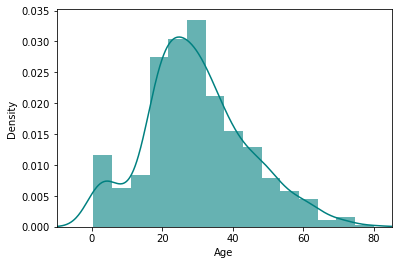

In [6]:
age_plot = train_data['Age'].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_data['Age'].plot(kind='density', color='teal')
age_plot.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

We will put median of the age's of missing age inputs!!

In [7]:
print('The median of "Age" is %.2f' %(train_data["Age"].median(skipna=True)))

The median of "Age" is 28.00


# 2.1.2 Cabin Missing Values

In [8]:
print('Percent of missing "Cabin" records is %.2f%%' %((train_data['Cabin'].isnull().sum()/train_data.shape[0])*100))

Percent of missing "Cabin" records is 77.10%


# 2.1.3 Embarked Missing Values

Percent of missing "Embarked" records is 0.22%
Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


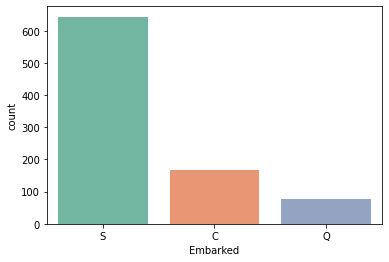

In [9]:
# percent of missing "Embarked" 
print('Percent of missing "Embarked" records is %.2f%%' %((train_data['Embarked'].isnull().sum()/train_data.shape[0])*100))
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_data['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_data, palette='Set2')
plt.show()

# 2.2 Data Manipulation

In [10]:
train_data_manip = train_data.copy()
train_data_manip["Age"].fillna(train_data["Age"].median(skipna=True), inplace=True)
train_data_manip["Embarked"].fillna(train_data['Embarked'].value_counts().idxmax(), inplace=True)
train_data_manip.drop('Cabin', axis=1, inplace=True)
train_data_manip.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Visualizing adjusted and raw data.

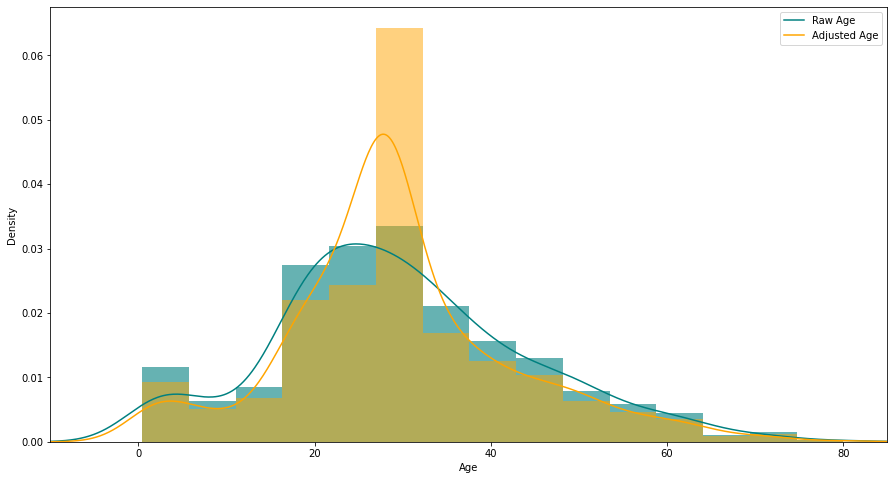

In [11]:
plt.figure(figsize=(15,8))
ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_data["Age"].plot(kind='density', color='teal')
ax = train_data_manip["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data_manip["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

# 2.3. Additional Variables

According to the Kaggle data dictionary, both SibSp and Parch relate to traveling with family. For simplicity's sake (and to account for possible multicollinearity), I'll combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

In [12]:
train_data_manip['TravelAlone']=np.where((train_data_manip["SibSp"]+train_data_manip["Parch"])>0, 0, 1)
train_data_manip.drop('SibSp', axis=1, inplace=True)
train_data_manip.drop('Parch', axis=1, inplace=True)

In [13]:
training=pd.get_dummies(train_data_manip, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


We will aplly same changes to the test data. 

In [14]:
test_data.isnull().sum()
test_data_manip = test_data.copy()
test_data_manip["Age"].fillna(train_data["Age"].median(skipna=True), inplace=True)
test_data_manip["Fare"].fillna(train_data["Fare"].median(skipna=True), inplace=True)
test_data_manip.drop('Cabin', axis=1, inplace=True)

test_data_manip['TravelAlone']=np.where((test_data_manip["SibSp"]+test_data_manip["Parch"])>0, 0, 1)

test_data_manip.drop('SibSp', axis=1, inplace=True)
test_data_manip.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data_manip, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


In [15]:
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

# 3. Logistic Regression Model and Prediction 

İn this part, Logistic regression model applied to the data. Firstly model is created, and then train and test data splitted. After the seperation, training is made. 

# 3.1 Feature Selection

Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Pclass_1', 'Pclass_2', 'Sex_male', 'IsMinor']


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Optimal number of features: 9
Selected features: ['Age', 'Fare', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


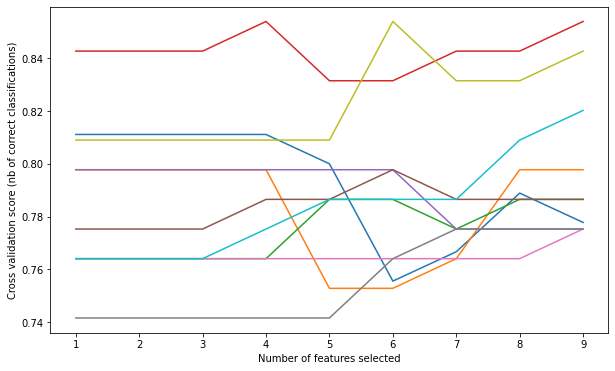

In [17]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

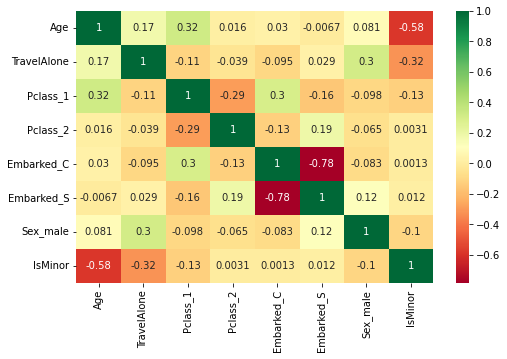

In [18]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

# 3.2 Model Training Based on train/test Split 

In [19]:
X = final_train[Selected_features]
y = final_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

Train/Test split results:
LogisticRegression accuracy is 0.782
LogisticRegression log_loss is 0.504
LogisticRegression auc is 0.838


# **4. Model Evaluation and Analysis**

# 4.1 Receiver Operating Characteristics (ROC Curve)

The receiving operating characteristic is a measure of classifier performance. Using the proportion of positive data points that are correctly considered as positive and the proportion of negative data points that are mistakenly considered as positive, we generate a graphic that shows the trade off between the rate at which you can correctly predict something with the rate of incorrectly predicting something. Ultimately, we’re concerned about the area under the ROC curve, or AUROC.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


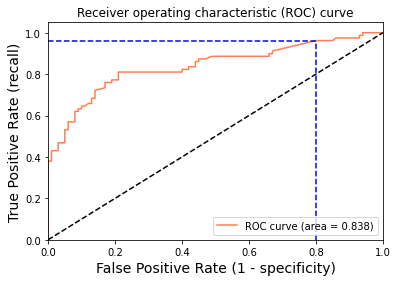

In [20]:
#Import roc_curve, auc
from sklearn.metrics import roc_curve, auc

y_train_score = logreg.decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

#Calculate the probability scores of each point in the test set
y_test_score = logreg.decision_function(X_test)

#Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)


#Plotting ROC curve
idx = np.min(np.where(tpr > 0.95))
plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

# **4.2 K-fold Cross-validation**

When evaluating models, we often want to assess how well it performs in predicting the target variable on different subsets of the data. One such technique for doing this is k-fold cross-validation, which partitions the data into k equally sized segments (called ‘folds’). One fold is held out for validation while the other k-1 folds are used to train the model and then used to predict the target variable in our testing data. This process is repeated k times, with the performance of each model in predicting the hold-out set being tracked using a performance metric such as accuracy. The most common variation of cross validation is 10-fold cross-validation.

In [21]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()), 
                         return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
                               if list(scoring.values())[sc]=='neg_log_loss' 
                               else results['test_%s' % list(scoring.values())[sc]].mean(), 
                               results['test_%s' % list(scoring.values())[sc]].std()))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


K-fold cross-validation results:
LogisticRegression average accuracy: 0.796 (+/-0.024)
LogisticRegression average log_loss: 0.454 (+/-0.037)
LogisticRegression average auc: 0.850 (+/-0.028)


# **5.Submission**

In [22]:
final_test['Survived'] = logreg.predict(final_test[Selected_features])
final_test['PassengerId'] = test_data['PassengerId']

submission = final_test[['PassengerId','Survived']]

submission.to_csv("submission.csv", index=False)

submission.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
